In [ ]:
import torch
from torch import Tensor
print(torch.__version__)

2.0.1+cu118


In [ ]:
# Install required packages.
import os
os.environ['TORCH'] = torch.__version__

!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install pyg-lib -f https://data.pyg.org/whl/nightly/torch-${TORCH}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

Looking in links: https://data.pyg.org/whl/torch-2.0.1+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 39.9 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.0.1+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 28.1 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/nightly/torch-2.0.1+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 2.8 MB/s eta 0:00:00
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-am2r87jw
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-am2r87jw
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit 48279b45ac0b3bdea68434eb3b61580cbb820825
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.4.0-py3-none-any.whl 

# Link Prediction on MovieLens

This colab notebook shows how to load a set of `*.csv` files as input and construct a heterogeneous graph from it.
We will then use this dataset as input into a [heterogeneous graph model](https://pytorch-geometric.readthedocs.io/en/latest/notes/heterogeneous.html#hgtutorial), and use it for the task of link prediction.

We are going to use the [MovieLens dataset](https://grouplens.org/datasets/movielens/) collected by the GroupLens research group.
This toy dataset describes ratings and tagging activity from MovieLens.
The dataset contains approximately 100k ratings across more than 9k movies from more than 600 users.
We are going to use this dataset to generate two node types holding data for movies and users, respectively, and one edge type connecting users and movies, representing the relation of whether a user has rated a specific movie.

The link prediction task then tries to predict missing ratings, and can, for example, be used to recommend users new movies.

The MovieLens datasets, first released in 1998, describe people’s expressed preferences for movies. These preferences take the form of tuples, each the result of a person expressing a preference (a 0-5 star rating) for a movie at a particular time. These preferences were entered by way of the MovieLens web site1 — a recommender system that asks its users to give movie ratings in order to receive personalized movie recommendations.



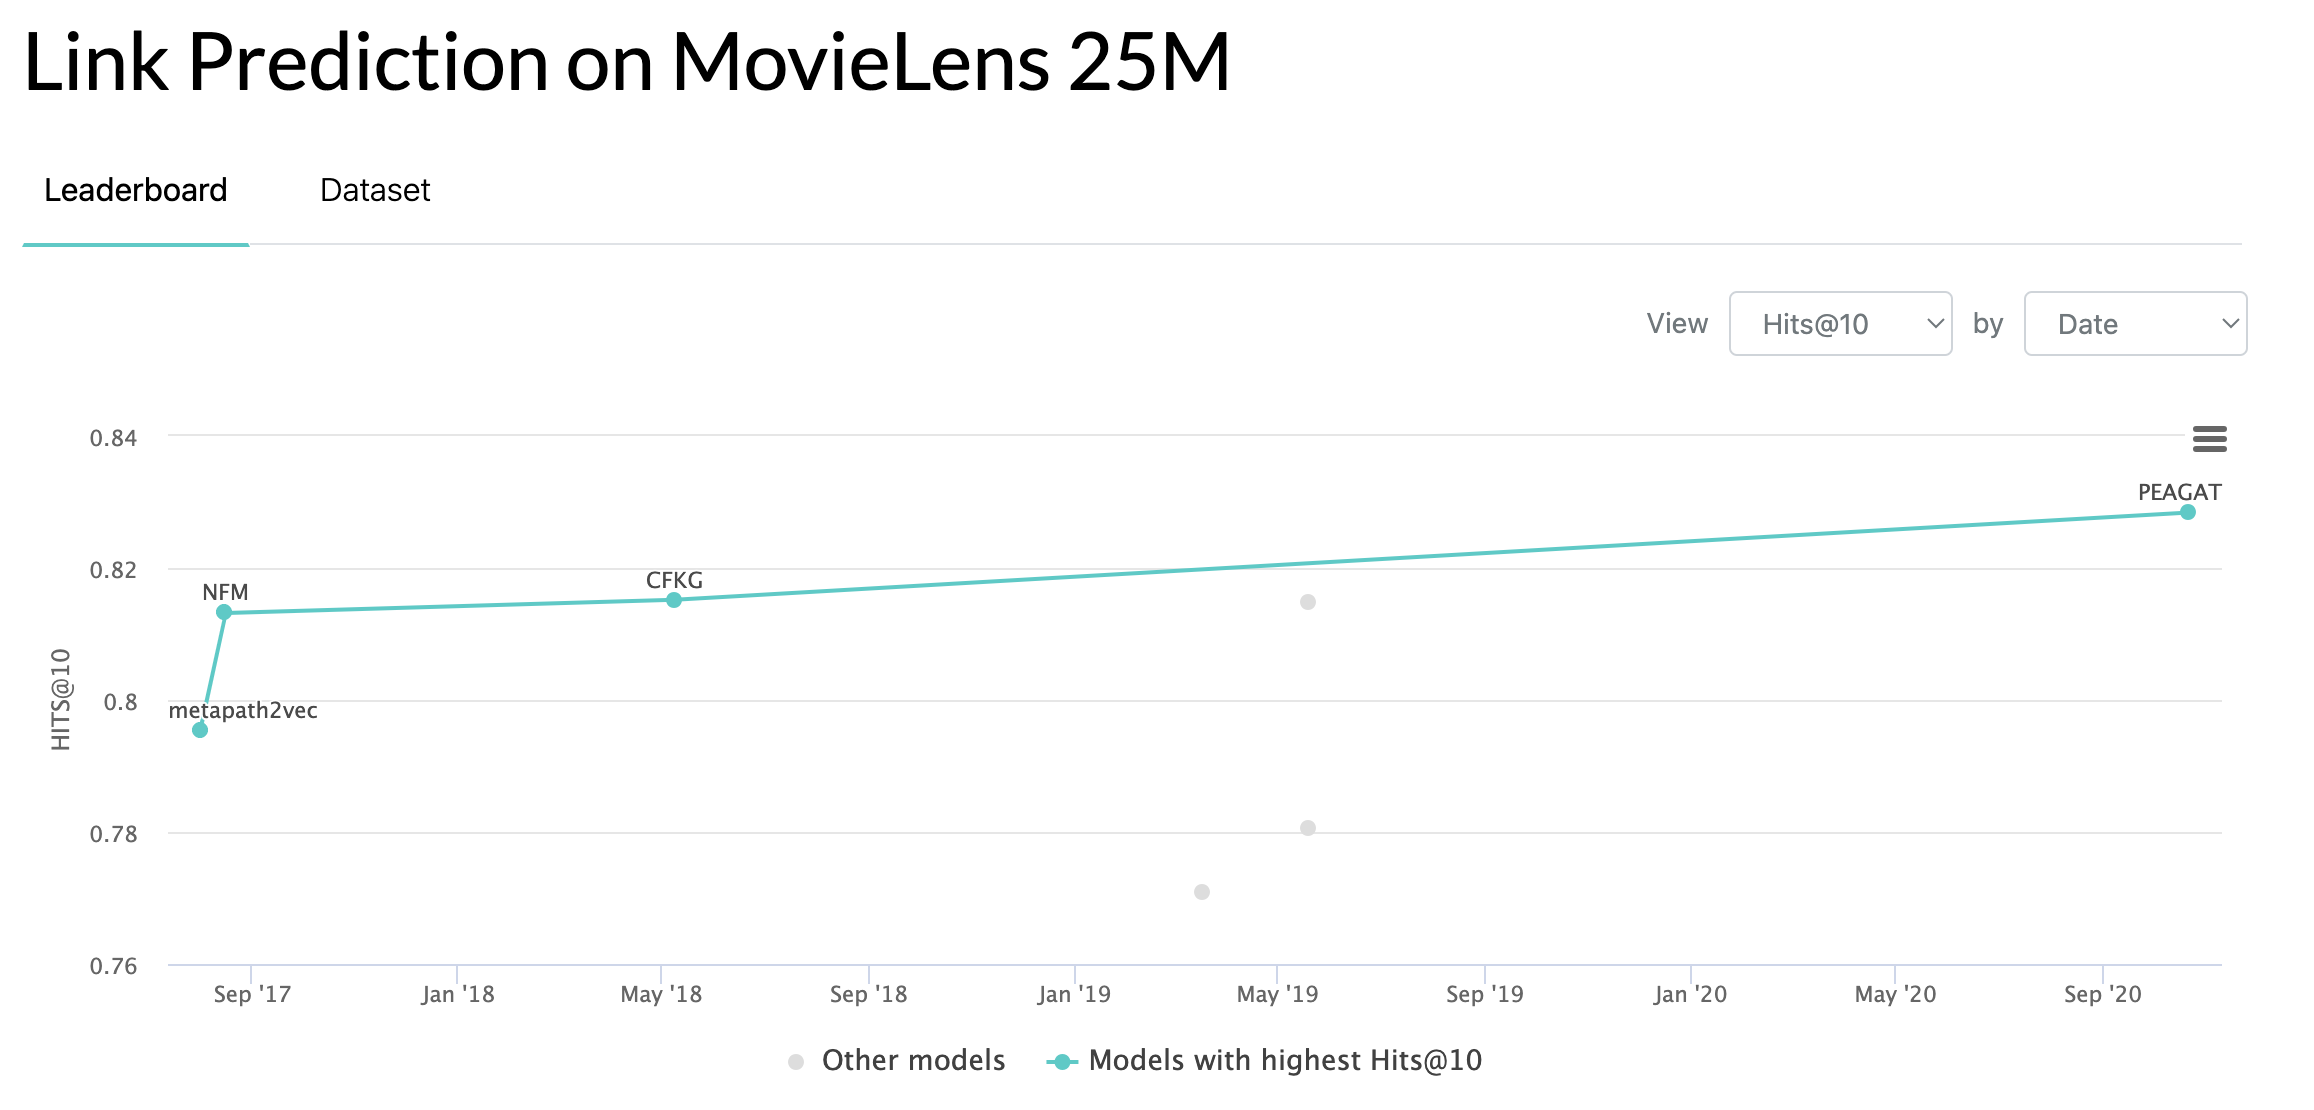

## Heterogeneous Graph Creation

First, we download the dataset to an arbitrary folder (in this case, the current directory):

In [ ]:
from torch_geometric.data import download_url, extract_zip

url = 'https://files.grouplens.org/datasets/movielens/ml-latest-small.zip'
extract_zip(download_url(url, '.'), '.')

movies_path = './ml-latest-small/movies.csv'
ratings_path = './ml-latest-small/ratings.csv'

Before we create the heterogeneous graph, let’s take a look at the data.

In [ ]:
import pandas as pd

print('movies.csv:')
print('===========')
print(pd.read_csv(movies_path)[["movieId", "genres"]].head())
print()
print('ratings.csv:')
print('============')
print(pd.read_csv(ratings_path)[["userId", "movieId"]].head())

We see that the `movies.csv` file provides two useful columns: `movieId` assigns a unique identifier to each movie, while the `genres` column represent genres of the given movie.
We can make use of this column to define a feature representation that can be easily interpreted by machine learning models.

In [ ]:
# Load the entire movie data frame into memory:
movies_df = pd.read_csv(movies_path, index_col='movieId')

# Split genres and convert into indicator variables:
genres = movies_df['genres'].str.get_dummies('|')
print(genres[["Action", "Adventure", "Drama", "Horror"]].head())

# Use genres as movie input features:
movie_feat = torch.from_numpy(genres.values).to(torch.float)
assert movie_feat.size() == (9742, 20)  # 20 genres in total.

The `ratings.csv` data connects users (as given by `userId`) and movies (as given by `movieId`).
Due to simplicity, we do not make use of the additional `timestamp` and `rating` information.
Here, we first read the `*.csv` file from disk, and create a mapping that maps entry IDs to a consecutive value in the range `{ 0, ..., num_rows - 1 }`.
This is needed as we want our final data representation to be as compact as possible, *e.g.*, the representation of a movie in the first row should be accessible via `x[0]`.

Afterwards, we obtain the final `edge_index` representation of shape `[2, num_ratings]` from `ratings.csv` by merging mapped user and movie indices with the raw indices given by the original data frame.

In [ ]:
# Load the entire ratings data frame into memory:
ratings_df = pd.read_csv(ratings_path)

# Create a mapping from unique user indices to range [0, num_user_nodes):
unique_user_id = ratings_df['userId'].unique()
unique_user_id = pd.DataFrame(data={
    'userId': unique_user_id,
    'mappedID': pd.RangeIndex(len(unique_user_id)),
})
print("Mapping of user IDs to consecutive values:")
print("==========================================")
print(unique_user_id.head())
print()
# Create a mapping from unique movie indices to range [0, num_movie_nodes):
unique_movie_id = ratings_df['movieId'].unique()
unique_movie_id = pd.DataFrame(data={
    'movieId': movies_df.index,
    'mappedID': pd.RangeIndex(len(movies_df)),
})
print("Mapping of movie IDs to consecutive values:")
print("===========================================")
print(unique_movie_id.head())

# Perform merge to obtain the edges from users and movies:
ratings_user_id = pd.merge(ratings_df['userId'], unique_user_id,
                            left_on='userId', right_on='userId', how='left')
ratings_user_id = torch.from_numpy(ratings_user_id['mappedID'].values)
ratings_movie_id = pd.merge(ratings_df['movieId'], unique_movie_id,
                            left_on='movieId', right_on='movieId', how='left')
ratings_movie_id = torch.from_numpy(ratings_movie_id['mappedID'].values)

# With this, we are ready to construct our `edge_index` in COO format
# following PyG semantics:
edge_index_user_to_movie = torch.stack([ratings_user_id, ratings_movie_id], dim=0)
assert edge_index_user_to_movie.size() == (2, 100836)

print()
print("Final edge indices pointing from users to movies:")
print("=================================================")
print(edge_index_user_to_movie)

With this, we are ready to initialize our `HeteroData` object and pass the necessary information to it.
Note that we also pass in a `node_id` vector to each node type in order to reconstruct the original node indices from sampled subgraphs.
We also take care of adding reverse edges to the `HeteroData` object.
This allows our GNN model to use both directions of the edge for message passing:

In [ ]:
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T

data = HeteroData()

# Save node indices:
data["user"].node_id = torch.arange(len(unique_user_id))
data["movie"].node_id = torch.arange(len(movies_df))

# Add the node features and edge indices:
data["movie"].x = ... # TODO
data["user", "rates", "movie"].edge_index = ... # TODO

# We also need to make sure to add the reverse edges from movies to users
# in order to let a GNN be able to pass messages in both directions.
# We can leverage the `T.ToUndirected()` transform for this from PyG:
data = T.ToUndirected()(data)

print(data)

assert data.node_types == ["user", "movie"]
assert data.edge_types == [("user", "rates", "movie"),
                           ("movie", "rev_rates", "user")]
assert data["user"].num_nodes == 610
assert data["user"].num_features == 0
assert data["movie"].num_nodes == 9742
assert data["movie"].num_features == 20
assert data["user", "rates", "movie"].num_edges == 100836
assert data["movie", "rev_rates", "user"].num_edges == 100836

## Defining Edge-level Training Splits

Since our data is now ready-to-be-used, we can split the ratings of users into training, validation, and test splits.
This is needed in order to ensure that we leak no information about edges used during evaluation into the training phase.
For this, we make use of the [`transforms.RandomLinkSplit`](https://pytorch-geometric.readthedocs.io/en/latest/modules/transforms.html#torch_geometric.transforms.RandomLinkSplit) transformation from PyG.
This transforms randomly divides the edges in the `("user", "rates", "movie")` into training, validation and test edges.
The `disjoint_train_ratio` parameter further separates edges in the training split into edges used for message passing (`edge_index`) and edges used for supervision (`edge_label_index`).
Note that we also need to specify the reverse edge type `("movie", "rev_rates", "user")`.
This allows the `RandomLinkSplit` transform to drop reverse edges accordingly to not leak any information into the training phase.

In [ ]:
# For this, we first split the set of edges into
# training (80%), validation (10%), and testing edges (10%).
# Across the training edges, we use 70% of edges for message passing,
# and 30% of edges for supervision.
# We further want to generate fixed negative edges for evaluation with a ratio of 2:1.
# Negative edges during training will be generated on-the-fly.
# We can leverage the `RandomLinkSplit()` transform for this from PyG:
## num_vel : int, optional (default: 0) The number of validation edges.
## num_test : int, optional (default: 0) The number of test edges.
## disjoint_train_ratio : float, optional (default: 0.8) The ratio of edges used for training.
## neg_sampling_ratio : float, optional (default: 1.0) The ratio of negative edges to positive edges.
transform = T.RandomLinkSplit(
    num_val=..., # TODO
    num_test=..., # TODO
    disjoint_train_ratio=..., # TODO
    neg_sampling_ratio=..., # TODO
    add_negative_train_samples=False,
    edge_types=("user", "rates", "movie"),
    rev_edge_types=("movie", "rev_rates", "user"),
)

train_data, val_data, test_data = transform(data)
print("Training data:")
print("==============")
print(train_data)
print()
print("Validation data:")
print("================")
print(val_data)

assert train_data["user", "rates", "movie"].num_edges == 56469
assert train_data["user", "rates", "movie"].edge_label_index.size(1) == 24201
assert train_data["movie", "rev_rates", "user"].num_edges == 56469
# No negative edges added:
assert train_data["user", "rates", "movie"].edge_label.min() == 1
assert train_data["user", "rates", "movie"].edge_label.max() == 1

assert val_data["user", "rates", "movie"].num_edges == 80670
assert val_data["user", "rates", "movie"].edge_label_index.size(1) == 30249
assert val_data["movie", "rev_rates", "user"].num_edges == 80670
# Negative edges with ratio 2:1:
assert val_data["user", "rates", "movie"].edge_label.long().bincount().tolist() == [20166, 10083]

## Defining Mini-batch Loaders

We are now ready to create a mini-batch loader that will generate subgraphs that can be used as input into our GNN.
While this step is not strictly necessary for small-scale graphs, it is absolutely necessary to apply GNNs on larger graphs that do not fit onto GPU memory otherwise.
Here, we make use of the [`loader.LinkNeighborLoader`](https://pytorch-geometric.readthedocs.io/en/latest/modules/loader.html#torch_geometric.loader.LinkNeighborLoader) which samples multiple hops from both ends of a link and creates a subgraph from it.
Here, `edge_label_index` serves as the "seed links" to start sampling from.

In [ ]:
# In the first hop, we sample at most 20 neighbors.
# In the second hop, we sample at most 10 neighbors.
# In addition, during training, we want to sample negative edges on-the-fly with
# a ratio of 2:1.
# We can make use of the `loader.LinkNeighborLoader` from PyG:
from torch_geometric.loader import LinkNeighborLoader

# Define seed edges:
edge_label_index = train_data["user", "rates", "movie"].edge_label_index
edge_label = train_data["user", "rates", "movie"].edge_label

train_loader = LinkNeighborLoader(
    data=..., # TODO
    num_neighbors=[20, 10],
    neg_sampling_ratio=..., # TODO
    edge_label_index=(("user", "rates", "movie"), edge_label_index),
    edge_label=edge_label,
    batch_size=128,
    shuffle=True,
)

# Inspect a sample:
sampled_data = next(iter(train_loader))

print("Sampled mini-batch:")
print("===================")
print(sampled_data)

assert sampled_data["user", "rates", "movie"].edge_label_index.size(1) == 3 * 128
assert sampled_data["user", "rates", "movie"].edge_label.min() == 0
assert sampled_data["user", "rates", "movie"].edge_label.max() == 1

## Creating a Heterogeneous Link-level GNN

We are now ready to create our heterogeneous GNN.
The GNN is responsible for learning enriched node representations from the surrounding subgraphs, which can be then used to derive edge-level predictions.
For defining our heterogenous GNN, we make use of [`nn.SAGEConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.SAGEConv) and the [`nn.to_hetero()`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.to_hetero_transformer.to_hetero) function, which transforms a GNN defined on homogeneous graphs to be applied on heterogeneous ones.

In addition, we define a final link-level classifier, which simply takes both node embeddings of the link we are trying to predict, and applies a dot-product on them.

As users do not have any node-level information, we choose to learn their features jointly via a `torch.nn.Embedding` layer. In order to improve the expressiveness of movie features, we do the same for movie nodes, and simply add their shallow embeddings to the pre-defined genre features.

In [ ]:
from torch_geometric.nn import SAGEConv, to_hetero
import torch.nn.functional as F

class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        # TODO: Create two `SAGEConv` layers, with hidden channels `hidden_channels` each.
        ## SAGEConv is a Graph Neural Network layer that performs message passing.
        self.conv1 = SAGEConv(hidden_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)

    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        x = ... # TODO: Apply first layer, with ReLU activation.
        x = ... # TODO: Apply second layer, with ReLU activation.
        return x

# Our final classifier applies the dot-product between source and destination
# node embeddings to derive edge-level predictions:
class Classifier(torch.nn.Module):
    def forward(self, x_user: Tensor, x_movie: Tensor, edge_label_index: Tensor) -> Tensor:
        # Convert node embeddings to edge-level representations:
        edge_feat_user = x_user[edge_label_index[0]]
        edge_feat_movie = x_movie[edge_label_index[1]]

        # Apply dot-product to get a prediction per supervision edge:
        return (edge_feat_user * edge_feat_movie).sum(dim=-1)


class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        # Since the dataset does not come with rich features, we also learn two
        # embedding matrices for users and movies:
        self.movie_lin = torch.nn.Linear(20, hidden_channels)
        self.user_emb = torch.nn.Embedding(data["user"].num_nodes, hidden_channels)
        self.movie_emb = torch.nn.Embedding(data["movie"].num_nodes, hidden_channels)

        # Instantiate homogeneous GNN:
        self.gnn = GNN(hidden_channels)

        # Convert GNN model into a heterogeneous variant:
        self.gnn = to_hetero(self.gnn, metadata=data.metadata())

        self.classifier = Classifier()

    def forward(self, data: HeteroData) -> Tensor:
        x_dict = {
          "user": self.user_emb(data["user"].node_id),
          "movie": self.movie_lin(data["movie"].x) + self.movie_emb(data["movie"].node_id),
        }

        # `x_dict` holds feature matrices of all node types
        # `edge_index_dict` holds all edge indices of all edge types
        x_dict = self.gnn(x_dict, data.edge_index_dict)
        pred = self.classifier(
            x_dict["user"],
            x_dict["movie"],
            data["user", "rates", "movie"].edge_label_index,
        )

        return pred


model = ... # TODO: Create model with hidden channels of your choice.

print(model)

## Training a Heterogeneous Link-level GNN

Training our GNN is then similar to training any PyTorch model.
We move the model to the desired device, and initialize an optimizer that takes care of adjusting model parameters via stochastic gradient descent.

The training loop then iterates over our mini-batches, applies the forward computation of the model, computes the loss from ground-truth labels and obtained predictions (here we make use of binary cross entropy), and adjusts model parameters via back-propagation and stochastic gradient descent.

In [ ]:
import tqdm
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: '{device}'")

model = model.to(device)
optimizer = ... # TODO: Create optimizer of your choice.

for epoch in range(1, 6):
    total_loss = total_examples = 0
    for sampled_data in tqdm.tqdm(train_loader):
        # TODO: Zero out the gradients.
        ...

        # TODO: Move data to device.
        ...
        # TODO: Perform forward pass.
        pred = ...

        ground_truth = sampled_data["user", "rates", "movie"].edge_label

        # TODO: Compute loss with `F.binary_cross_entropy_with_logits`.
        loss = ...

        # TODO: Perform backward pass.
        ...
        # TODO: Perform optimization step.
        ...

        total_loss += float(loss) * pred.numel()
        total_examples += pred.numel()
    print(f"Epoch: {epoch:03d}, Loss: {total_loss / total_examples:.4f}")

## Evaluating a Heterogeneous Link-level GNN

After training, we evaluate our model on useen data coming from the validation set.
For this, we define a new `LinkNeighborLoader` (which now iterates over the edges in the validation set), obtain the predictions on validation edges by running the model, and finally evaluate the performance of the model by computing the AUC score over the set of predictions and their corresponding ground-truth edges (including both positive and negative edges).

In [ ]:
# Define the validation seed edges:
edge_label_index = val_data["user", "rates", "movie"].edge_label_index
edge_label = val_data["user", "rates", "movie"].edge_label

val_loader = LinkNeighborLoader(
    data=val_data,
    num_neighbors=[20, 10],
    edge_label_index=(("user", "rates", "movie"), edge_label_index),
    edge_label=edge_label,
    batch_size=3 * 128,
    shuffle=False,
)

sampled_data = next(iter(val_loader))

print("Sampled mini-batch:")
print("===================")
print(sampled_data)

assert sampled_data["user", "rates", "movie"].edge_label_index.size(1) == 3 * 128
assert sampled_data["user", "rates", "movie"].edge_label.min() >= 0
assert sampled_data["user", "rates", "movie"].edge_label.max() <= 1

In [ ]:
from sklearn.metrics import roc_auc_score

preds = []
ground_truths = []
for sampled_data in tqdm.tqdm(val_loader):
    with torch.no_grad():
        sampled_data.to(device)
        preds.append(model(sampled_data))
        ground_truths.append(sampled_data["user", "rates", "movie"].edge_label)

pred = torch.cat(preds, dim=0).cpu().numpy()
ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()
auc = roc_auc_score(ground_truth, pred)
print()
print(f"Validation AUC: {auc:.4f}")